<a href="https://colab.research.google.com/github/anantagr/C-sharp/blob/master/Anant_New_doner_ANN_Lag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing required libraries

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pickle



### Loading the data

In [87]:
emails_data = pd.read_csv('/content/drive/Shared drives/RA2 TechCareers Model Data/emails.csv', error_bad_lines=False, header = 0)
interactions_data = pd.read_csv('/content/drive/Shared drives/RA2 TechCareers Model Data/interactions.csv', error_bad_lines=False, header = 0)
persons_data = pd.read_csv('/content/drive/Shared drives/RA2 TechCareers Model Data/persons.csv', error_bad_lines=False, header = 0)



From the above data, we draw a list of dependent and independent features.
List of Dependent features: 
1. Customer will open the email (1 or 0)



### Reading the data

In [88]:
df_emails = pd.DataFrame(emails_data)
df_interactions = pd.DataFrame(interactions_data)
df_persons = pd.DataFrame(persons_data)

print(df_emails.shape)
print(df_interactions.shape)
print(df_persons.shape)


(609, 11)
(1044769, 8)
(21066, 14)


# **Part 1 - Preprocessing the data**


### Email.csv

In [89]:
# Filtering out emails sent to less than 500 recipients 
df_emails = df_emails[df_emails['recipients'] > 500].reset_index(drop=True)

# Dropping unused columns
df_emails = df_emails.drop(['broadcaster_id', 'recipients', 'subject_line','content', 'opened', 'clicked', 'bad', 'bounced', 'spam', 'sent_time'], 1)

print(df_emails.shape)
df_emails.head()

(207, 1)


,email_id
0,100
1,104
2,105
3,11
4,117


## Interactions.csv

#### Converting Opened_time data to 0s and 1s

- 0 means email not opened
- 1 means email was opened

In [90]:
# drop extra columns
df_interations_filtered = df_interactions[['email_id', 'user_id', 'sent_time', 'opened_time']]

# convert columns to datatimes
df_interations_filtered['opened_time'], df_interations_filtered['sent_time'] = pd.to_datetime(df_interations_filtered['opened_time']), pd.to_datetime(df_interations_filtered['sent_time'])

# check if email was opened
df_interations_filtered['opened'] = df_interations_filtered.opened_time.notnull()

# filter out emails that were not sent to user
df_interations_filtered = df_interations_filtered[df_interations_filtered.sent_time.notnull()]


#drop unused columns
df_interations_filtered = df_interations_filtered.drop(['opened_time'], 1)


# check column types
df_interations_filtered.dtypes


# Create lag columns
# Order the data by user and time sent
interaction_ordered = df_interations_filtered.sort_values(['user_id', 'sent_time'], ascending=False)



# Create lagged columns by lopping through number of lag terms
interaction_lagged = interaction_ordered

lag_steps = 5 # sets the number of lags to use
for i in range(lag_steps):
  interaction_lagged['Open_Lag' + str(i+1)] = interaction_lagged.groupby('user_id')['opened'].shift(-1 * (i+1))


# Filter out rows wth missing lag terms and drop extra columns
opened_lag_data = interaction_ordered[interaction_ordered['Open_Lag'+str(lag_steps)].notnull()].drop(['sent_time'], axis = 1)
# # open_lag_data = open_lag_data.groupby('opened').apply(lambda x: x.sample(300000))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Persons.csv

* Creating dummy variable (is_donor) for user_ID
  * If user_ID donated ----------------> is_donor = 1
  * If user_ID did not donated ----> is_donor = 0

* Creating dummy variable for is_member & is_volunteer
  * True = 1
  * False = 0

### Cleaning data

In [91]:
# Gender divided in 3 categories: 1) Male (2) Female (3) Other
for i in range(len(df_persons['gender'])):
  if ((df_persons.at[i,'gender'] != 'MALE') and (df_persons.at[i,'gender'] != 'FEMALE')):
    df_persons.at[i,'gender'] = 'OTHERS'

# is_volumteer divided in 3 categories: 1) True (2) False (3) No Data
for i in range(len(df_persons['is_volunteer'])):
  if ((df_persons.at[i,'is_volunteer'] != True) and (df_persons.at[i,'is_volunteer'] != False)):
    df_persons.at[i,'is_volunteer'] = 'No Data'

# City Data cleaning
# Dropping cities with NA vlues
df_persons = df_persons.dropna(subset=['city'])

# Cities divided in 3 categories: 1) Edmonton (2) Calgary (3) Other
df_persons['city'] = np.where(
   (df_persons['city'] !='EDMONTON') & (df_persons['city'] != 'CALGARY') , 'OTHER', df_persons['city']
   )


#Checking dataset
print('Persons dataset: ', df_persons.shape)
# print(df_persons.info())
print("Unique genders in dataset: ", df_persons['gender'].unique())
print("Unique is_volunteer in dataset: ", df_persons['is_volunteer'].unique())
print("Unique Cities in dataset: ", df_persons['city'].unique())



# Convert categorical features into dummy variables
Gender = pd.get_dummies(df_persons['gender'], prefix='gender_', drop_first=True)
df_persons = pd.concat([df_persons, Gender], axis = 1)

Is_volunteer = pd.get_dummies(df_persons['is_volunteer'], prefix='is_volunteer_',  drop_first=True)
df_persons = pd.concat([df_persons, Is_volunteer], axis = 1)

City = pd.get_dummies(df_persons['city'], prefix='city_',  drop_first=True)
df_persons = pd.concat([df_persons, City], axis = 1)

# Creating column is_donor
df_persons['is_donor'] = np.where(df_persons.amount_donated_in_cent > 0, 1, 0)

# Changing true to 1 and false to 0
df_persons[["is_member", "do_not_call", "do_not_contact", "mobile_opt_in", "email_opt_in"]] *= 1

print('Persons dataset after creating dummy variables: ', df_persons.shape)


#Dropping unused columns
df_persons = df_persons.drop(['created_at', 'amount_donated_in_cent', 'gender', 'genderscale', 'is_volunteer', 'city', 'lat', 'lng'], 1)

print('Persons dataset after dropping unused columns: ', df_persons.shape)

df_persons.head()


Persons dataset:  (17737, 14)
Unique genders in dataset:  ['MALE' 'FEMALE' 'OTHERS']
Unique is_volunteer in dataset:  [True False 'No Data']
Unique Cities in dataset:  ['EDMONTON' 'OTHER' 'CALGARY']
Persons dataset after creating dummy variables:  (17737, 21)
Persons dataset after dropping unused columns:  (17737, 13)


,user_id,do_not_call,do_not_contact,mobile_opt_in,email_opt_in,is_member,gender__MALE,gender__OTHERS,is_volunteer__True,is_volunteer__No Data,city__EDMONTON,city__OTHER,is_donor
0,10,0,0,1,1,1,1,0,1,0,1,0,1
1,100,0,0,1,1,1,1,0,0,0,0,1,0
2,1000,0,0,1,0,1,1,0,0,0,0,1,0
3,10000,0,0,1,1,1,0,0,0,0,0,1,1
4,10001,0,0,1,0,1,1,0,0,0,1,0,1


# Combining Email, Interactions and Persons dataframes

#### **Email Dataframe**
*   Unique Email IDs ---> 207

  (Removed emails sent to less than 500 recipients)


#### **Interactions Dataframe**
*   Unique Email IDs ---> 562
*   Unique User IDs ---> 21066



#### **Persons Dataframe**
*   Unique User IDs ---> 17737

```
df_persons['user_id'].nunique()
```






#### **Inner join** between Interaction DF and Email DF on email_id

#### **Inner join** between Interaction DF and Persons DF on email_id

[Info](https://https://www.diffen.com/difference/Inner_Join_vs_Outer_Join)





In [92]:
#Inner join between Interaction DF and Email DF on email_id 
df_combined = pd.merge(opened_lag_data, df_emails, on='email_id', how='inner')

#Inner join between Interaction DF and Persons DF on user_id 
df_combined2 = pd.merge(df_combined, df_persons, on='user_id', how='inner')

# taking 250k opened and 250k not opened email
df_combined_final = df_combined2.groupby('opened').apply(lambda x: x.sample(250000))

# Changing true to 1 and false to 0
df_combined_final[["opened", "Open_Lag1", "Open_Lag2", "Open_Lag3", "Open_Lag4", "Open_Lag5"]] *= 1


# Final Data set

* 500000 rows × 18 columns
* Unique Emaild IDs ---> 168 nos.
* Unique User IDs ---> 13929 nos.

`df_combined_final.nunique()`

In [93]:
df_combined_final

email_id  user_id  opened  ... city__EDMONTON city__OTHER is_donor
opened                                    ...                                    
False  73952         55     9954       0  ...              0           0        1
       578975       197     5066       0  ...              0           0        1
       207559       611    20377       0  ...              0           1        1
       54206        550    11225       0  ...              0           1        1
       275328       416    16608       0  ...              0           1        1
...                 ...      ...     ...  ...            ...         ...      ...
True   575975       677     5185       1  ...              0           1        1
       708271       658     3090       1  ...              0           1        0
       183962       694    22792       1  ...              0           1        1
       806034       162     5353       1  ...              0           1        0
       778636       468    17202       1  ...              0           0        0

[500000 rows x 20 columns]

#### Features and Target in dataset

In [94]:
#Selecting Target
y=df_combined_final['opened']

#Selecting Features (17 nos.)
X = df_combined_final.drop(['opened', 'email_id', 'user_id'], axis = 1)

# Splitting the data set into:
* Training set (95% i.e. 500000 rows)
* Validation set (5% of Taining set i.e. 45000 rows)
* Final Testing set (5% i.e. 50000 rows)

In [95]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [96]:
# # Feature Scaling
# # This will convert all features in same scale which is between standard normal distribution
# # Using library StandardScaler
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [97]:
X_train

Open_Lag1 Open_Lag2  ... city__OTHER is_donor
opened                             ...                     
False  592152         0         0  ...           1        0
       364579         0         0  ...           0        1
True   588948         0         0  ...           1        1
False  596977         0         0  ...           0        0
       73757          1         0  ...           0        1
...                 ...       ...  ...         ...      ...
True   710605         1         1  ...           0        1
False  618943         0         0  ...           0        1
True   78044          1         1  ...           0        1
       377416         1         1  ...           0        1
       311538         1         0  ...           1        0

[450000 rows x 17 columns]

# **Part 2 - Now let's make the ANN!!**




*   12 input features
*   Layer 1 ---> 12 neurons
*   Layer 2 ---> 10 neurons
*   Layer 3 ---> 8 neurons
*   Layer 4 ---> 6 neurons
*   Output Layer  ---> 1 neurons

Output will be with 0 or 1
* 0 means did not open the email
* 1 means opened the email


Activation function:
* RELU ---> For hidden layers
* Sigmoid ---> For output layer



In [98]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential #This helps to create a sequential neural network
from keras.layers import Dense #This helps in creating neuron in hidden layers
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


# Initialising the ANN
classifier = Sequential()


# Adding the input layer and the first hidden layer
classifier.add(Dense(activation="relu", input_dim=17, units=12, kernel_initializer="he_uniform")) 
# 'Dense' -------------> will help to construct the neurons
# 'input_dim = 14' ----> because we have 12 input features
# 'units = 6' ----> because we are passing outputs to 6 neurons of first hidden layer
# 'ikernel_initializer = 'he_uniform'-> so that all the weights are initialized uniformally i.e. between 0 to 1
# 'activation='relu' --> because we are using RELU activation function


# Adding the second hidden layer
classifier.add(Dense(activation="relu", units=10, kernel_initializer="he_uniform"))

# Adding the third hidden layer
classifier.add(Dense(activation="relu", units=8, kernel_initializer="he_uniform"))

# Adding the fourth hidden layer
classifier.add(Dense(activation="relu", units=6, kernel_initializer="he_uniform"))

# Adding the output layer
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="glorot_uniform"))
# 'units = 1' -------> because we are passing final outputs to 1 neuron of output layer
# 'activation='sigmoid' --> because we are using Sigmoid activation function

# Check the structure summary using 'classifier.summary()'


# Compiling the ANN
classifier.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])

# 'optimizer = 'Adamax' ---> Intialized the optimizer called 'Adamax'
# 'loss = 'binary_crossentropy' ---> Because we are expecting only two outputs, 0 or 1

# Fitting the ANN to the Training set
model_history = classifier.fit(X_train, y_train,validation_split=0.1, batch_size = 10, epochs = 100, verbose = 1)
# 'nb_epoch = 100' ---> Number of times, forward propagation and back propagation will run to adjust weights and reduce loss


# save the classifier to disk
filename = '/content/drive/Shared drives/RA2 TechCareers Model Data/pkl_folder/new_donor_classifier.sav'
pickle.dump(classifier, open(filename, 'wb'))

# save the model to disk
filename = '/content/drive/Shared drives/RA2 TechCareers Model Data/pkl_folder/new_donor_history_model.sav'
pickle.dump(model_history, open(filename, 'wb'))





Train on 405000 samples, validate on 45000 samples
Epoch 1/100
405000/405000 [==============================] - 120s 295us/step - loss: 0.4993 - accuracy: 0.7584 - val_loss: 0.4931 - val_accuracy: 0.7640
Epoch 2/100
405000/405000 [==============================] - 119s 294us/step - loss: 0.4967 - accuracy: 0.7597 - val_loss: 0.4925 - val_accuracy: 0.7618
Epoch 3/100
405000/405000 [==============================] - 120s 296us/step - loss: 0.4965 - accuracy: 0.7598 - val_loss: 0.4914 - val_accuracy: 0.7625
Epoch 4/100
405000/405000 [==============================] - 118s 292us/step - loss: 0.4963 - accuracy: 0.7599 - val_loss: 0.4923 - val_accuracy: 0.7640
Epoch 5/100
405000/405000 [==============================] - 122s 300us/step - loss: 0.4961 - accuracy: 0.7598 - val_loss: 0.4913 - val_accuracy: 0.7634
Epoch 6/100
405000/405000 [==============================] - 120s 296us/step - loss: 0.4962 - accuracy: 0.7600 - val_loss: 0.4918 - val_accuracy: 0.7640
Epoch 7/100
405000/405000 [====

[Adamax Initializer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adamax)

In [99]:
# load the classifier from disk
filename = '/content/drive/Shared drives/RA2 TechCareers Model Data/pkl_folder/new_donor_classifier.sav'
loaded_classifier = pickle.load(open(filename, 'rb'))

# load the model from disk
filename = '/content/drive/Shared drives/RA2 TechCareers Model Data/pkl_folder/new_donor_history_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))



In [100]:
loaded_classifier.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 12)                216       
_________________________________________________________________
dense_47 (Dense)             (None, 10)                130       
_________________________________________________________________
dense_48 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 7         
Total params: 495
Trainable params: 495
Non-trainable params: 0
_________________________________________________________________


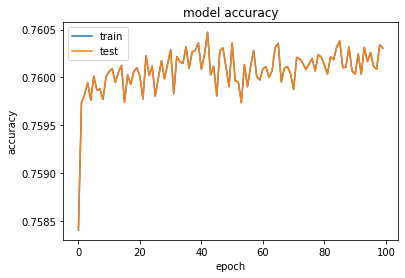

In [101]:
# summarize history for accuracy
plt.plot(loaded_model.history['accuracy'])
plt.plot(loaded_model.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

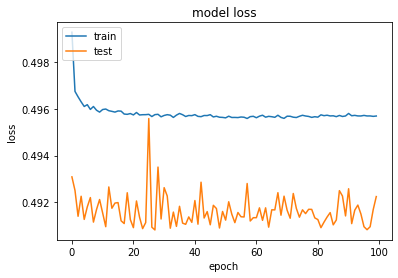

In [102]:
# summarize history for loss
plt.plot(loaded_model.history['loss'])
plt.plot(loaded_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Part 3 - Making the predictions and evaluating the model**


In [103]:
# Predicting the Test set results
y_pred = loaded_classifier.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [104]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[18956,  6023],
       [ 6063, 18958]])

In [105]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)

score

0.75828